# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 08.02.2024.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов.

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-a.tgz

--2024-02-22 17:30:35--  http://vis-www.cs.umass.edu/lfw/lfw-a.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14486641 (14M) [application/x-gzip]
Saving to: ‘lfw-a.tgz’

lfw-a.tgz           100%[===================>]  13.82M   945KB/s    in 11s     

2024-02-22 17:30:46 (1.28 MB/s) - ‘lfw-a.tgz’ saved [14486641/14486641]



In [ ]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [ ]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

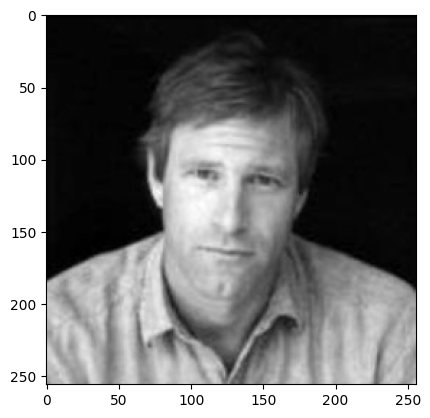

In [ ]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [ ]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [ ]:
images_list = []
for name in images:
  for k in range(0, np.array(images[name]).shape[0]):
    images_list.append(np.array(images[name][k]))

In [ ]:
images_list = np.array(images_list)

In [ ]:
M = images_list.transpose(2,1,0).reshape(-1, images_list.shape[0])

In [ ]:
M.shape

(65536, 1053)

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.

    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [ ]:
from numpy.linalg import svd

U, S, VT = svd(M, full_matrices=False)

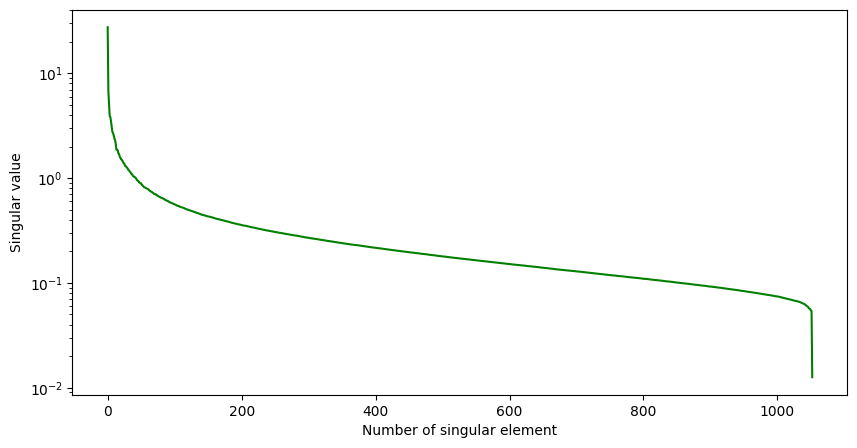

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('Singular value', fontsize=10)
plt.xlabel('Number of singular element', fontsize=10)
plt.semilogy(S, color='green', label='Singular values')

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [ ]:
U.shape

(65536, 1053)

In [ ]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:, i * cols + j].reshape((size, size)), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)

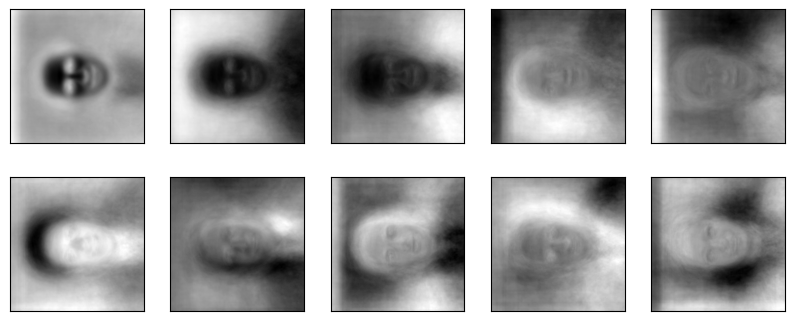

In [ ]:
plot_as_images(U, 2, 5)

Судя по всему, первые три вектора отвечают за форму лица.

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [ ]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation

        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''

    U, S, V = np.linalg.svd(M, full_matrices=False)

    Sr = np.diag(S[:r])
    Ur = U[:, :r]
    Vr = V[:r, :]

    Mr = Ur @ Sr @ Vr

    C = Sr @ Vr
    rel_accuracy = np.linalg.norm(np.diag(S[r:])) / np.linalg.norm(np.diag(S))
    return Ur, C, rel_accuracy

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [ ]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:, index].reshape(256, 256), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(appr.reshape(256, 256), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:, i].reshape(256, 256), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))

        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)


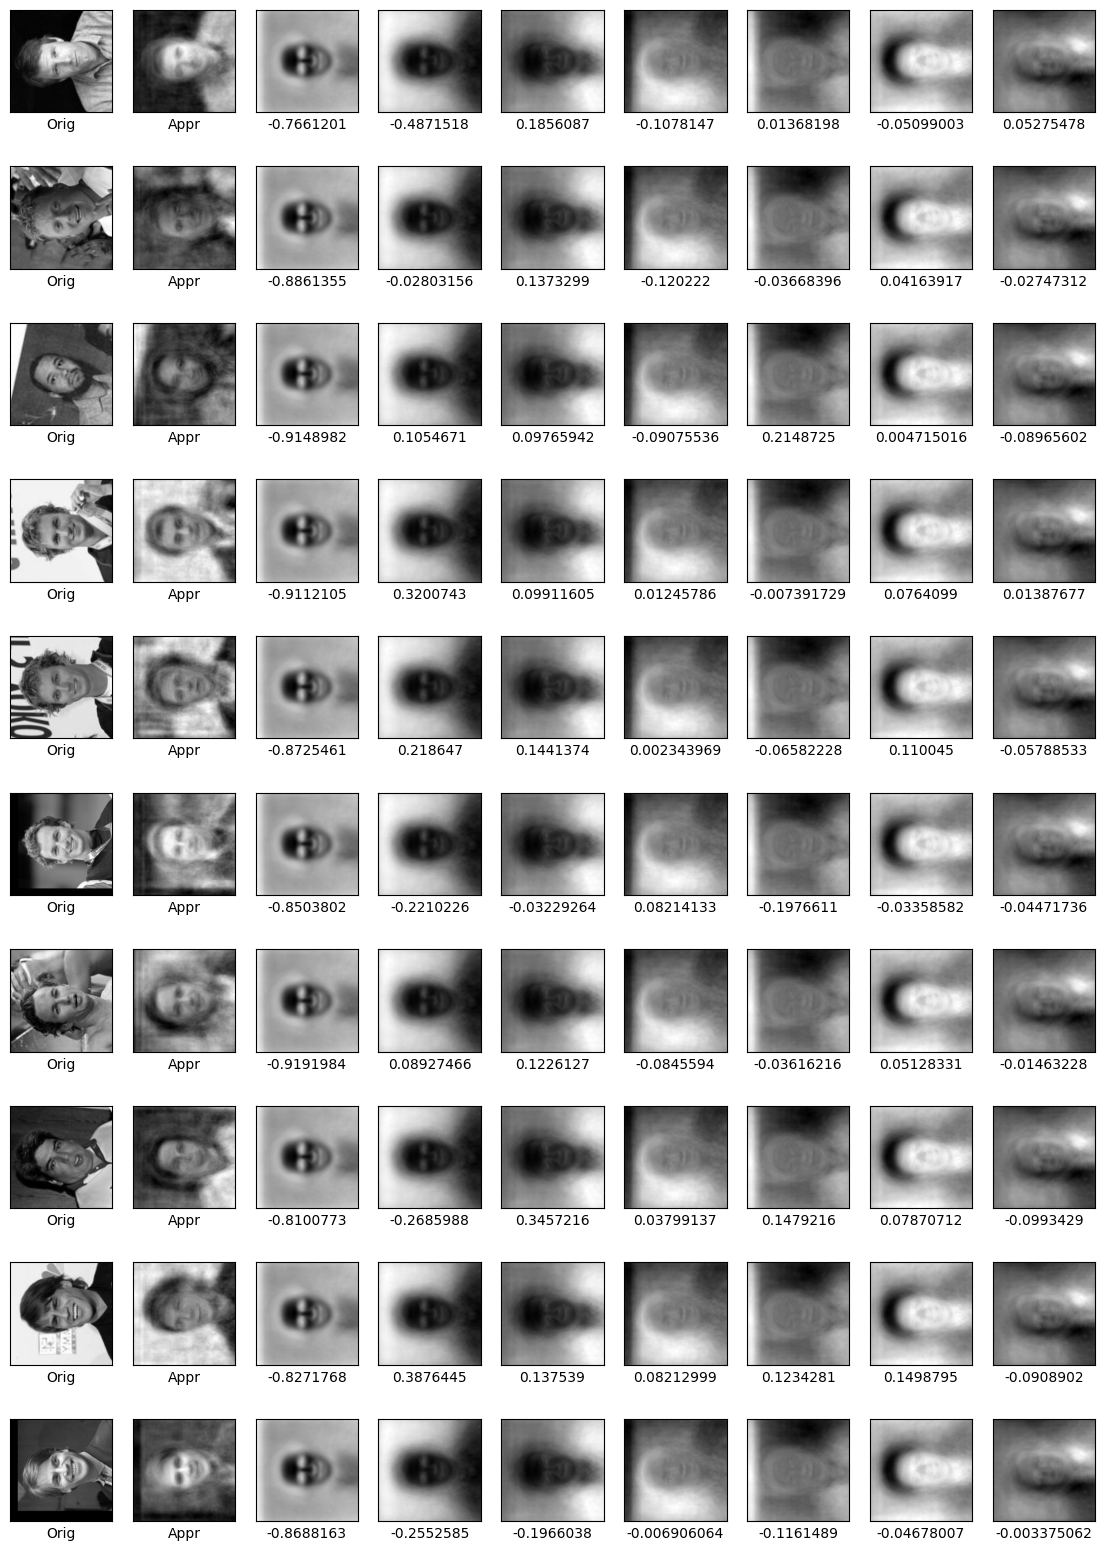

In [ ]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [ ]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''

    omega = np.random.randn(M.shape[1], r + p)
    Q, R = np.linalg.qr(M @ omega)
    U, S, V = np.linalg.svd(Q.T @ M, full_matrices=False)
    Mr = Q @ U[:, :r] @ np.diag(S[:r]) @ V[:r, :]
    rel_eps = np.linalg.norm(M - Mr) / np.linalg.norm(M)
    return Mr, rel_eps



2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [ ]:
from tqdm import tqdm


100%|██████████| 21/21 [22:26<00:00, 64.11s/it]


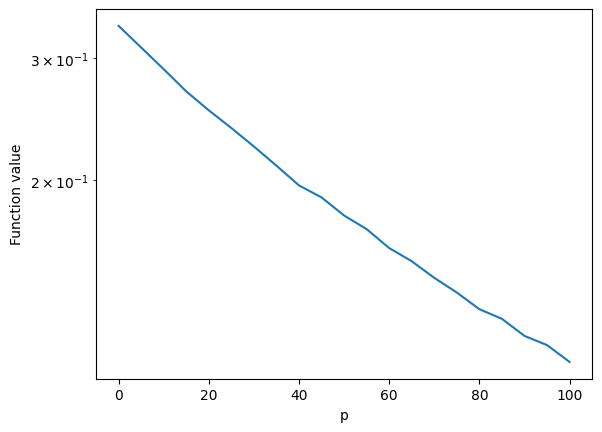

In [ ]:
def plot_func(M):
    p_values = range(0, 101, 5)
    y_values = []
    for p in tqdm(p_values):
        diffs = 0
        for _ in range(10):
            Mr, rel_eps = rand_svd(M, 50, p)
            diffs += rel_eps
        diffs /= 10
        Ur, C, rell_eps = trunc_svd(M, 50)
        y_values.append((diffs / rell_eps) - 1)
    plt.semilogy(p_values, y_values)
    plt.xlabel('p')
    plt.ylabel('Function value')
    plt.show()

plot_func(M)

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [ ]:
import timeit
mean_trunc_time = 0
for i in range(10):
  start = timeit.default_timer()
  Ur, CC, rell_eps = trunc_svd(M, 50)
  mean_trunc_time += timeit.default_timer() - start
mean_trunc_time /= 10


In [ ]:
print("Trunc svd average work time :", mean_trunc_time)

Trunc svd average work time : 39.274707333


In [ ]:
mean_rand_time = 0
for i in range(10):
  start = timeit.default_timer()
  M, rell_eps = rand_svd(M, 50)
  mean_rand_time += timeit.default_timer() - start
mean_rand_time /= 10
print("Random svd average work time :", mean_rand_time)

Random svd average work time : 2.5946696612000553


In [ ]:
print("Difference between trunc and rand svd is appproximately {} times".format(mean_trunc_time / mean_rand_time))

Difference between trunc and rand svd is appproximately 15.13668885110991 times


In [ ]:
mean_def_time = 0
for i in range(10):
  start = timeit.default_timer()
  UU, S, V = svd(M, full_matrices = False)
  mean_def_time += timeit.default_timer() - start
mean_def_time /= 10

In [ ]:
print("Default svd average work time :", mean_def_time)

Default svd average work time : 30.366219157099955


In [ ]:
print("Difference between default and rand svd is appproximately {} times".format(mean_def_time / mean_rand_time))

Difference between default and rand svd is appproximately 11.703308367607512 times


### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [ ]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [ ]:
M.shape #1053 вектора по 65536 - должен получиться вектор из 1053 норм

(65536, 1053)

In [ ]:
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list of count indices of closest images
    """
    distances = np.linalg.norm(M - new_v.reshape(256 * 256, 1), axis=0)
    indexed_distances = list(enumerate(distances))

    sorted_distances = sorted(indexed_distances, key=lambda x: x[1])
    indices = [index for index, distance in sorted_distances[:count]]

    return indices

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

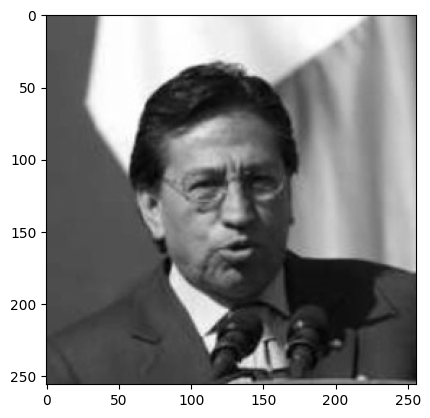

In [ ]:
new = test_image
_ = plt.imshow(new, cmap="gray")

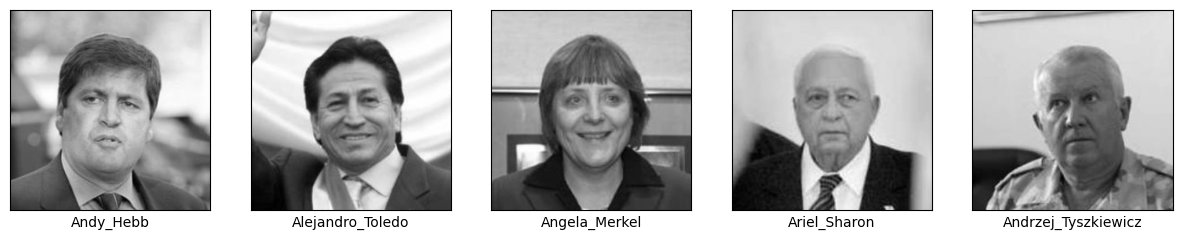

In [ ]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [ ]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list (of len `count`) of indices of closest images
    """
    new_v_proj = U.T @ new_v
    new_v_proj = np.reshape(new_v_proj, (100, 1))
    distances = np.linalg.norm(C[:,1:] - new_v_proj, axis=0)

    indexed_distances = list(enumerate(distances))

    sorted_distances = sorted(indexed_distances, key=lambda x: x[1])
    indices = [index for index, distance in sorted_distances[:count]]
    return indices

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

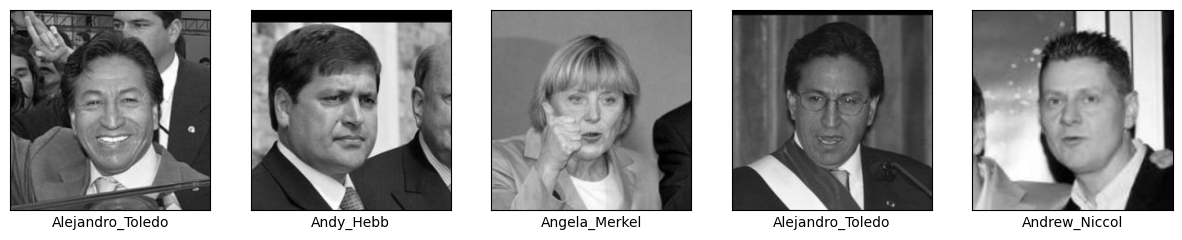

In [ ]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [40]:
def rand_subsp_iter(A, l, q):
  m, n = A.shape[0], A.shape[1]
  A = np.matrix(A)
  omega = np.random.normal(0, 1, (n, l))
  Y = A @ omega
  Q, R = np.linalg.qr(Y)
  for j in range(0, q):
    Yj = A.H @ Q;
    Qj, Rj = np.linalg.qr(Yj)
    Yjj = A @ Qj
    Q, R = np.linalg.qr(Yjj)
  return Q

In [41]:
def rand_svd_prot(A, r, q):
  Q = rand_subsp_iter(A, q, 5)
  U, S, V = np.linalg.svd(Q.T @ A, full_matrices = False)
  Mr = Q @ U[:, :r] @ np.diag(S[:r]) @ V[:r, :]
  return Mr

In [42]:
def optimal_approximation(A, r):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    Ar = U[:, :r] @ np.diag(S[:r]) @ V[:r, :]
    return Ar

In [30]:
import tqdm

In [43]:
ranks = [5, 20, 50]
qs = range(1, 101, 5)

errors = []
for q in qs:
    Mr = rand_svd_prot(M, 5, q)
    Ms = optimal_approximation(M, 5)
    error = np.linalg.norm(Mr - Ms, 'fro')
    errors.append(error)


In [44]:
errors2 = []
for q in tqdm.tqdm(qs):
    Mr = rand_svd_prot(M, 20, q)
    Ms = optimal_approximation(M, 20)
    error = np.linalg.norm(Mr - Ms, 'fro')
    errors2.append(error)

errors3 = []
for q in tqdm.tqdm(qs):
    Mr = rand_svd_prot(M, 50, q)
    Ms = optimal_approximation(M, 50)
    error = np.linalg.norm(Mr - Ms, 'fro')
    errors3.append(error)

100%|██████████| 20/20 [13:16<00:00, 39.83s/it]


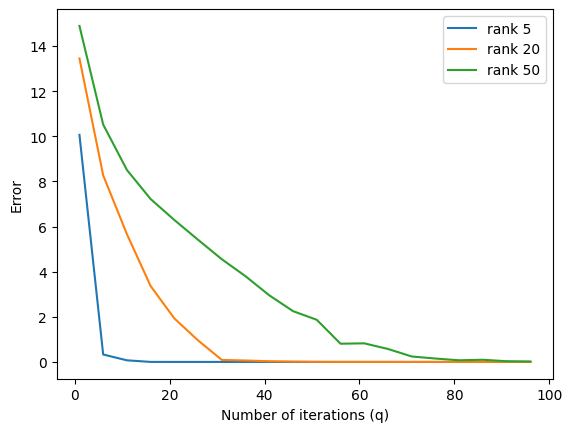

In [45]:
plt.figure()
plt.plot(qs, errors, label = 'rank 5')
plt.plot(qs, errors2, label = 'rank 20')
plt.plot(qs, errors3, label = 'rank 50')
plt.xlabel('Number of iterations (q)')
plt.ylabel('Error')
plt.legend()
plt.show()

По-видимому, мораль состоит в том, что чем большего ранга мы хотим сделать приближение - тем больше итераций нужно для того, чтобы оно было качественным